### **Model training**
### This progrom is similar to trainer.py, compare to trainer.py, it contains more illustrations fo the model training workflow, such as dataset check and dynacmic result visuallization.



In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
from model.seg_model.model_scales_gate import unet_scales_gate
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*pad*.tif'))
paths_des = sorted(glob.glob(config.dir_des+'/*pad*.tif'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*pad*.tif'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(len(paths_as))
print(paths_as[0])


39
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/scene01_s1as_pad.tif


In [4]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
### 1.1. training scenes selection (in the application, all scenes are used for training.)
tra_scenes, tra_truths = read_normalize(paths_as=paths_as, paths_des=paths_des, \
                            paths_truth=paths_truth, max_bands=config.s1_max, min_bands=config.s1_min)
# ### !!!!extract either ascending or descending image.
# tra_scenes = [s[2:4] for s in tra_scenes]        ## [0:2] -> ascending; [2:4] -> descending

### 1.2. training data loading
tra_scenes = [tra_scenes[id] for id in config.tra_ids]    ## select the training scenes
tra_truths = [tra_truths[id] for id in config.tra_ids]
tra_dset = threads_scene_dset(scene_list = tra_scenes, \
                              truth_list = tra_truths, 
                              transforms=config.transforms_tra, 
                              num_thread=30)   ##  num_thread(30) patches per scene.

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
# # !!!extract either ascending or descending image for validation
# for i in range(len(patch_list_val)):
#    for j in range(len(patch_list_val[0][0])):
#       patch_list_val[i][0][j] = patch_list_val[i][0][j][2:4]   ## [0:2] -> ascending; [2:4] -> descending

val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())



size of training data: 870
size of val data: 500


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


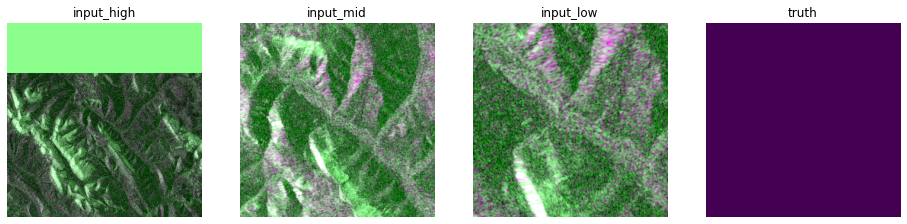

In [6]:
## check training data
for patches, truth in tra_loader:
    patches = patches
    break
patches_ = [patch.to('cpu').detach().numpy().transpose(0,2,3,1).astype(np.float32) for patch in patches]
patches_[0].shape
patches_list = [patches_[0][0],patches_[1][0],patches_[2][0], truth[0].numpy().transpose(1,2,0)]
patches_name = ['input_high','input_mid','input_low','truth']
clip_list = [1,1,1,1]
col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0)]
plt.figure(figsize=(16,5))
imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)


In [11]:
## ------------ Model ------------ ##
## -------- 3. gated multiple scales -------
model = unet_scales_gate(num_bands=4, num_classes=2, \
                    scale_high=2048, scale_mid=512, scale_low=256).to(device)


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                          mode='min', factor=0.6, patience=10)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [13]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred,_,_ = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred,_,_ = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            # x_batch = x_batch[2]      # !!!note: x_batch[2] for single-scale model
            y_batch = config.label_smooth(y_batch)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                        optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)         # dynamic adjust learning rate using ReduceLROnPlateau
        # lr_scheduler.step()                 # dynamic adjust learning rate using StepLR

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = [batch.to(device).to(dtype=torch.float32) for batch in x_batch], y_batch.to(device)    
            # x_batch = x_batch[2]          #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: Tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, Val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},Time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device).to(dtype=torch.float32) for patch in patches]
            truth = truth.to(device)
            # pred = model(patches[2])           # !!! note: x[2] for single-scale model
            pred, gate_mid, gate_high = model(patches)            
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            # gate_mid = gate_mid.to('cpu').detach().numpy()
            # gate_high = gate_high.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patches_list = patches + [truth, pred]
            # patches_list = patches + [gate_high[0][0], gate_mid[0][0]] + [truth, pred]
            # ---- plot result
            # print(f'gate_mid:{gate_mid[0,0,0,0]:.2f}, gate_high:{gate_high[0,0,0,0]:.2f}')
            plt.figure(figsize=(14,4))
            # patches_name = ['input_high','input_mid','input_low','gate_high','gate_mid','truth','pred']
            patches_name = ['input_high','input_mid','input_low','truth','pred']
            clip_list = [2,2,2,0,0]
            col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics


Ep1: Tra-> Loss:0.589,Oa:0.658,Miou:0.532, Val-> Loss:0.478,Oa:0.796,Miou:0.588,Time:11.2s
Ep2: Tra-> Loss:0.433,Oa:0.689,Miou:0.530, Val-> Loss:0.440,Oa:0.839,Miou:0.584,Time:11.1s
Ep3: Tra-> Loss:0.425,Oa:0.746,Miou:0.597, Val-> Loss:0.407,Oa:0.859,Miou:0.605,Time:11.8s
Ep4: Tra-> Loss:0.412,Oa:0.788,Miou:0.684, Val-> Loss:0.437,Oa:0.878,Miou:0.547,Time:11.4s
Ep5: Tra-> Loss:0.415,Oa:0.790,Miou:0.649, Val-> Loss:0.338,Oa:0.872,Miou:0.687,Time:11.4s
Ep6: Tra-> Loss:0.405,Oa:0.850,Miou:0.694, Val-> Loss:0.338,Oa:0.815,Miou:0.687,Time:11.1s
Ep7: Tra-> Loss:0.406,Oa:0.793,Miou:0.654, Val-> Loss:0.357,Oa:0.856,Miou:0.650,Time:11.5s
Ep8: Tra-> Loss:0.410,Oa:0.824,Miou:0.651, Val-> Loss:0.385,Oa:0.871,Miou:0.507,Time:11.6s
Ep9: Tra-> Loss:0.403,Oa:0.824,Miou:0.706, Val-> Loss:0.410,Oa:0.876,Miou:0.551,Time:11.0s
Ep10: Tra-> Loss:0.399,Oa:0.858,Miou:0.723, Val-> Loss:0.315,Oa:0.851,Miou:0.709,Time:10.9s


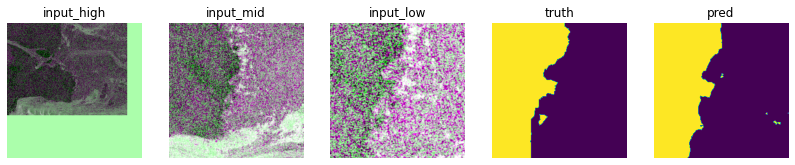

Ep11: Tra-> Loss:0.400,Oa:0.844,Miou:0.676, Val-> Loss:0.335,Oa:0.806,Miou:0.689,Time:11.3s
Ep12: Tra-> Loss:0.404,Oa:0.796,Miou:0.678, Val-> Loss:0.369,Oa:0.815,Miou:0.615,Time:11.0s
Ep13: Tra-> Loss:0.399,Oa:0.840,Miou:0.698, Val-> Loss:0.304,Oa:0.881,Miou:0.710,Time:11.2s
Ep14: Tra-> Loss:0.385,Oa:0.859,Miou:0.734, Val-> Loss:0.292,Oa:0.874,Miou:0.740,Time:11.5s
Ep15: Tra-> Loss:0.389,Oa:0.823,Miou:0.721, Val-> Loss:0.349,Oa:0.879,Miou:0.644,Time:11.1s
Ep16: Tra-> Loss:0.397,Oa:0.861,Miou:0.716, Val-> Loss:0.391,Oa:0.883,Miou:0.602,Time:11.4s
Ep17: Tra-> Loss:0.399,Oa:0.848,Miou:0.691, Val-> Loss:0.335,Oa:0.897,Miou:0.666,Time:11.4s
Ep18: Tra-> Loss:0.401,Oa:0.865,Miou:0.748, Val-> Loss:0.404,Oa:0.813,Miou:0.580,Time:11.6s
Ep19: Tra-> Loss:0.388,Oa:0.845,Miou:0.720, Val-> Loss:0.317,Oa:0.915,Miou:0.703,Time:11.4s
Ep20: Tra-> Loss:0.367,Oa:0.856,Miou:0.765, Val-> Loss:0.287,Oa:0.903,Miou:0.766,Time:11.3s


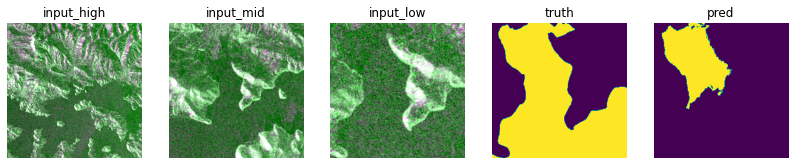

Ep21: Tra-> Loss:0.384,Oa:0.856,Miou:0.758, Val-> Loss:0.305,Oa:0.867,Miou:0.741,Time:11.5s
Ep22: Tra-> Loss:0.389,Oa:0.874,Miou:0.756, Val-> Loss:0.275,Oa:0.925,Miou:0.777,Time:11.3s
Ep23: Tra-> Loss:0.371,Oa:0.881,Miou:0.798, Val-> Loss:0.347,Oa:0.896,Miou:0.624,Time:11.3s
Ep24: Tra-> Loss:0.387,Oa:0.852,Miou:0.698, Val-> Loss:0.293,Oa:0.914,Miou:0.785,Time:11.3s
Ep25: Tra-> Loss:0.383,Oa:0.865,Miou:0.754, Val-> Loss:0.272,Oa:0.920,Miou:0.803,Time:11.2s
Ep26: Tra-> Loss:0.375,Oa:0.886,Miou:0.789, Val-> Loss:0.306,Oa:0.914,Miou:0.706,Time:11.2s
Ep27: Tra-> Loss:0.385,Oa:0.891,Miou:0.752, Val-> Loss:0.246,Oa:0.939,Miou:0.842,Time:11.3s
Ep28: Tra-> Loss:0.374,Oa:0.881,Miou:0.765, Val-> Loss:0.430,Oa:0.886,Miou:0.568,Time:11.5s
Ep29: Tra-> Loss:0.387,Oa:0.874,Miou:0.733, Val-> Loss:0.244,Oa:0.940,Miou:0.842,Time:11.2s
Ep30: Tra-> Loss:0.386,Oa:0.878,Miou:0.760, Val-> Loss:0.448,Oa:0.876,Miou:0.539,Time:11.5s


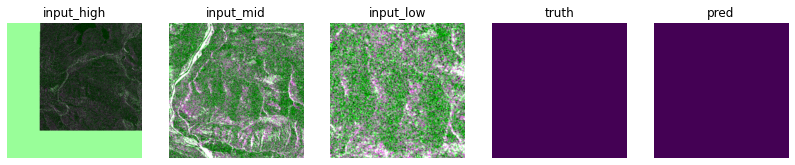

Ep31: Tra-> Loss:0.402,Oa:0.875,Miou:0.735, Val-> Loss:0.311,Oa:0.887,Miou:0.723,Time:11.4s
Ep32: Tra-> Loss:0.373,Oa:0.895,Miou:0.813, Val-> Loss:0.289,Oa:0.909,Miou:0.729,Time:11.1s
Ep33: Tra-> Loss:0.366,Oa:0.914,Miou:0.818, Val-> Loss:0.215,Oa:0.941,Miou:0.875,Time:11.1s
Ep34: Tra-> Loss:0.371,Oa:0.909,Miou:0.801, Val-> Loss:0.293,Oa:0.910,Miou:0.673,Time:11.2s
Ep35: Tra-> Loss:0.372,Oa:0.905,Miou:0.819, Val-> Loss:0.228,Oa:0.954,Miou:0.857,Time:11.4s
Ep36: Tra-> Loss:0.377,Oa:0.884,Miou:0.782, Val-> Loss:0.311,Oa:0.873,Miou:0.698,Time:11.2s
Ep37: Tra-> Loss:0.381,Oa:0.850,Miou:0.746, Val-> Loss:0.265,Oa:0.940,Miou:0.744,Time:11.6s
Ep38: Tra-> Loss:0.370,Oa:0.881,Miou:0.785, Val-> Loss:0.237,Oa:0.943,Miou:0.798,Time:11.3s
Ep39: Tra-> Loss:0.373,Oa:0.882,Miou:0.791, Val-> Loss:0.241,Oa:0.907,Miou:0.798,Time:11.6s
Ep40: Tra-> Loss:0.368,Oa:0.886,Miou:0.809, Val-> Loss:0.261,Oa:0.939,Miou:0.777,Time:11.5s


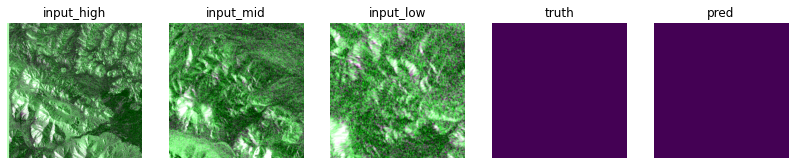

Ep41: Tra-> Loss:0.369,Oa:0.916,Miou:0.845, Val-> Loss:0.199,Oa:0.963,Miou:0.877,Time:11.6s
Ep42: Tra-> Loss:0.368,Oa:0.897,Miou:0.809, Val-> Loss:0.232,Oa:0.935,Miou:0.836,Time:11.4s
Ep43: Tra-> Loss:0.370,Oa:0.881,Miou:0.790, Val-> Loss:0.204,Oa:0.965,Miou:0.881,Time:11.6s
Ep44: Tra-> Loss:0.364,Oa:0.895,Miou:0.818, Val-> Loss:0.264,Oa:0.917,Miou:0.716,Time:11.4s
Ep45: Tra-> Loss:0.376,Oa:0.888,Miou:0.781, Val-> Loss:0.225,Oa:0.941,Miou:0.871,Time:11.2s
Ep46: Tra-> Loss:0.362,Oa:0.911,Miou:0.830, Val-> Loss:0.185,Oa:0.952,Miou:0.895,Time:11.8s
Ep47: Tra-> Loss:0.365,Oa:0.901,Miou:0.811, Val-> Loss:0.207,Oa:0.941,Miou:0.875,Time:11.7s
Ep48: Tra-> Loss:0.378,Oa:0.889,Miou:0.792, Val-> Loss:0.216,Oa:0.941,Miou:0.843,Time:11.7s
Ep49: Tra-> Loss:0.379,Oa:0.887,Miou:0.791, Val-> Loss:0.343,Oa:0.895,Miou:0.665,Time:11.5s
Ep50: Tra-> Loss:0.362,Oa:0.912,Miou:0.832, Val-> Loss:0.199,Oa:0.948,Miou:0.895,Time:12.0s


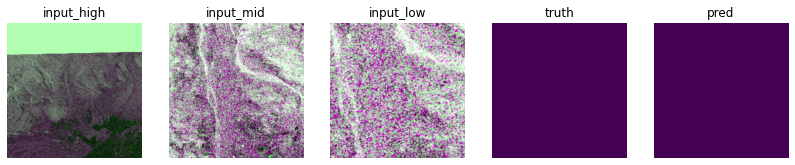

Ep51: Tra-> Loss:0.367,Oa:0.890,Miou:0.789, Val-> Loss:0.182,Oa:0.956,Miou:0.895,Time:11.7s
Ep52: Tra-> Loss:0.355,Oa:0.923,Miou:0.861, Val-> Loss:0.242,Oa:0.945,Miou:0.763,Time:11.4s
Ep53: Tra-> Loss:0.376,Oa:0.879,Miou:0.753, Val-> Loss:0.341,Oa:0.877,Miou:0.643,Time:11.4s
Ep54: Tra-> Loss:0.365,Oa:0.917,Miou:0.831, Val-> Loss:0.230,Oa:0.941,Miou:0.798,Time:11.8s
Ep55: Tra-> Loss:0.352,Oa:0.940,Miou:0.871, Val-> Loss:0.221,Oa:0.945,Miou:0.836,Time:12.0s
Ep56: Tra-> Loss:0.357,Oa:0.925,Miou:0.840, Val-> Loss:0.230,Oa:0.899,Miou:0.808,Time:12.1s
Ep57: Tra-> Loss:0.367,Oa:0.920,Miou:0.850, Val-> Loss:0.209,Oa:0.930,Miou:0.865,Time:11.7s
Ep58: Tra-> Loss:0.365,Oa:0.919,Miou:0.841, Val-> Loss:0.192,Oa:0.964,Miou:0.890,Time:11.7s
Ep59: Tra-> Loss:0.359,Oa:0.917,Miou:0.833, Val-> Loss:0.230,Oa:0.941,Miou:0.815,Time:11.5s
Ep60: Tra-> Loss:0.364,Oa:0.912,Miou:0.839, Val-> Loss:0.222,Oa:0.958,Miou:0.825,Time:11.3s


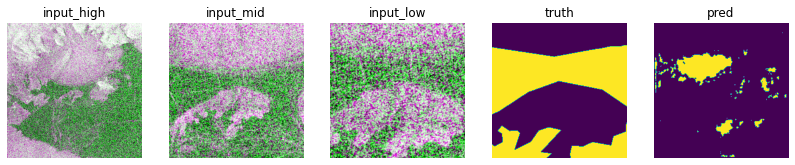

Ep61: Tra-> Loss:0.361,Oa:0.916,Miou:0.835, Val-> Loss:0.194,Oa:0.943,Miou:0.888,Time:11.8s
Ep62: Tra-> Loss:0.353,Oa:0.933,Miou:0.864, Val-> Loss:0.200,Oa:0.939,Miou:0.864,Time:11.8s
Ep63: Tra-> Loss:0.364,Oa:0.930,Miou:0.867, Val-> Loss:0.203,Oa:0.963,Miou:0.858,Time:11.4s
Ep64: Tra-> Loss:0.368,Oa:0.933,Miou:0.823, Val-> Loss:0.193,Oa:0.956,Miou:0.883,Time:11.6s
Ep65: Tra-> Loss:0.352,Oa:0.903,Miou:0.851, Val-> Loss:0.200,Oa:0.954,Miou:0.871,Time:11.6s
Ep66: Tra-> Loss:0.352,Oa:0.942,Miou:0.854, Val-> Loss:0.210,Oa:0.953,Miou:0.835,Time:11.8s
Ep67: Tra-> Loss:0.380,Oa:0.902,Miou:0.790, Val-> Loss:0.334,Oa:0.893,Miou:0.654,Time:11.4s
Ep68: Tra-> Loss:0.366,Oa:0.884,Miou:0.811, Val-> Loss:0.395,Oa:0.882,Miou:0.573,Time:11.5s
Ep69: Tra-> Loss:0.373,Oa:0.906,Miou:0.775, Val-> Loss:0.244,Oa:0.945,Miou:0.808,Time:11.6s
Ep70: Tra-> Loss:0.361,Oa:0.899,Miou:0.827, Val-> Loss:0.240,Oa:0.934,Miou:0.772,Time:11.7s


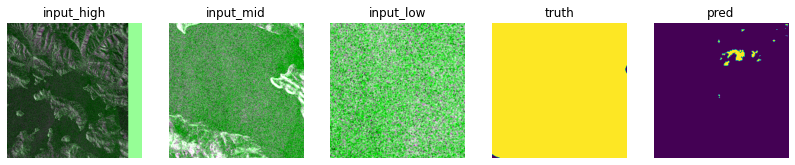

Ep71: Tra-> Loss:0.357,Oa:0.947,Miou:0.863, Val-> Loss:0.260,Oa:0.895,Miou:0.749,Time:12.0s
Ep72: Tra-> Loss:0.364,Oa:0.904,Miou:0.829, Val-> Loss:0.197,Oa:0.938,Miou:0.861,Time:11.8s
Ep73: Tra-> Loss:0.363,Oa:0.928,Miou:0.844, Val-> Loss:0.224,Oa:0.940,Miou:0.789,Time:11.3s
Ep74: Tra-> Loss:0.360,Oa:0.916,Miou:0.847, Val-> Loss:0.240,Oa:0.933,Miou:0.786,Time:11.9s
Ep75: Tra-> Loss:0.358,Oa:0.914,Miou:0.834, Val-> Loss:0.287,Oa:0.883,Miou:0.704,Time:11.6s
Ep76: Tra-> Loss:0.363,Oa:0.906,Miou:0.831, Val-> Loss:0.206,Oa:0.925,Miou:0.873,Time:11.9s
Ep77: Tra-> Loss:0.367,Oa:0.910,Miou:0.823, Val-> Loss:0.207,Oa:0.944,Miou:0.824,Time:11.6s
Ep78: Tra-> Loss:0.347,Oa:0.943,Miou:0.882, Val-> Loss:0.190,Oa:0.949,Miou:0.865,Time:11.8s
Ep79: Tra-> Loss:0.357,Oa:0.912,Miou:0.844, Val-> Loss:0.212,Oa:0.950,Miou:0.828,Time:11.7s
Ep80: Tra-> Loss:0.359,Oa:0.912,Miou:0.849, Val-> Loss:0.277,Oa:0.923,Miou:0.729,Time:11.6s


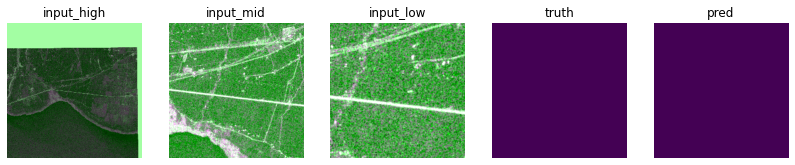

Ep81: Tra-> Loss:0.363,Oa:0.923,Miou:0.845, Val-> Loss:0.226,Oa:0.908,Miou:0.853,Time:12.0s
Ep82: Tra-> Loss:0.360,Oa:0.905,Miou:0.839, Val-> Loss:0.184,Oa:0.950,Miou:0.892,Time:12.2s
Ep83: Tra-> Loss:0.350,Oa:0.955,Miou:0.891, Val-> Loss:0.177,Oa:0.947,Miou:0.897,Time:11.8s
Ep84: Tra-> Loss:0.357,Oa:0.918,Miou:0.864, Val-> Loss:0.235,Oa:0.936,Miou:0.784,Time:11.7s
Ep85: Tra-> Loss:0.368,Oa:0.933,Miou:0.842, Val-> Loss:0.209,Oa:0.934,Miou:0.888,Time:11.6s
Ep86: Tra-> Loss:0.353,Oa:0.922,Miou:0.873, Val-> Loss:0.205,Oa:0.955,Miou:0.849,Time:11.3s
Ep87: Tra-> Loss:0.353,Oa:0.918,Miou:0.841, Val-> Loss:0.207,Oa:0.948,Miou:0.871,Time:11.6s
Ep88: Tra-> Loss:0.352,Oa:0.913,Miou:0.841, Val-> Loss:0.189,Oa:0.943,Miou:0.891,Time:11.4s
Ep89: Tra-> Loss:0.348,Oa:0.937,Miou:0.860, Val-> Loss:0.172,Oa:0.967,Miou:0.906,Time:11.8s
Ep90: Tra-> Loss:0.349,Oa:0.948,Miou:0.891, Val-> Loss:0.177,Oa:0.961,Miou:0.893,Time:11.8s


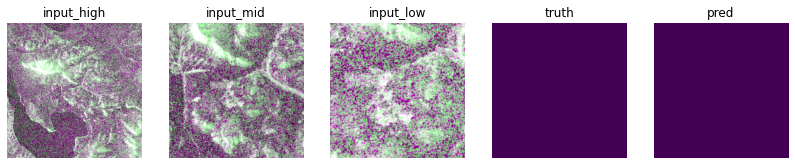

Ep91: Tra-> Loss:0.353,Oa:0.922,Miou:0.860, Val-> Loss:0.183,Oa:0.963,Miou:0.895,Time:11.8s
Ep92: Tra-> Loss:0.352,Oa:0.916,Miou:0.865, Val-> Loss:0.187,Oa:0.967,Miou:0.891,Time:11.5s
Ep93: Tra-> Loss:0.361,Oa:0.905,Miou:0.844, Val-> Loss:0.198,Oa:0.952,Miou:0.878,Time:11.9s
Ep94: Tra-> Loss:0.347,Oa:0.927,Miou:0.855, Val-> Loss:0.204,Oa:0.960,Miou:0.850,Time:11.8s
Ep95: Tra-> Loss:0.351,Oa:0.935,Miou:0.858, Val-> Loss:0.236,Oa:0.947,Miou:0.796,Time:11.7s
Ep96: Tra-> Loss:0.344,Oa:0.958,Miou:0.889, Val-> Loss:0.216,Oa:0.948,Miou:0.832,Time:11.2s
Ep97: Tra-> Loss:0.342,Oa:0.948,Miou:0.902, Val-> Loss:0.213,Oa:0.953,Miou:0.847,Time:11.4s
Ep98: Tra-> Loss:0.344,Oa:0.947,Miou:0.869, Val-> Loss:0.195,Oa:0.951,Miou:0.871,Time:12.0s
Ep99: Tra-> Loss:0.343,Oa:0.942,Miou:0.897, Val-> Loss:0.198,Oa:0.950,Miou:0.872,Time:11.4s
Ep100: Tra-> Loss:0.340,Oa:0.940,Miou:0.891, Val-> Loss:0.222,Oa:0.929,Miou:0.831,Time:11.8s


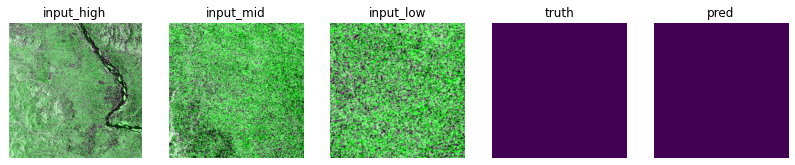

Ep101: Tra-> Loss:0.346,Oa:0.928,Miou:0.864, Val-> Loss:0.201,Oa:0.951,Miou:0.850,Time:11.7s
Ep102: Tra-> Loss:0.356,Oa:0.935,Miou:0.876, Val-> Loss:0.175,Oa:0.964,Miou:0.903,Time:11.8s
Ep103: Tra-> Loss:0.351,Oa:0.939,Miou:0.880, Val-> Loss:0.190,Oa:0.943,Miou:0.879,Time:11.4s
Ep104: Tra-> Loss:0.348,Oa:0.924,Miou:0.865, Val-> Loss:0.187,Oa:0.960,Miou:0.879,Time:12.0s
Ep105: Tra-> Loss:0.352,Oa:0.949,Miou:0.888, Val-> Loss:0.194,Oa:0.958,Miou:0.882,Time:11.4s
Ep106: Tra-> Loss:0.356,Oa:0.947,Miou:0.864, Val-> Loss:0.194,Oa:0.961,Miou:0.883,Time:11.7s
Ep107: Tra-> Loss:0.345,Oa:0.921,Miou:0.872, Val-> Loss:0.189,Oa:0.952,Miou:0.869,Time:11.5s
Ep108: Tra-> Loss:0.348,Oa:0.933,Miou:0.870, Val-> Loss:0.223,Oa:0.946,Miou:0.832,Time:12.3s
Ep109: Tra-> Loss:0.352,Oa:0.937,Miou:0.868, Val-> Loss:0.193,Oa:0.960,Miou:0.878,Time:11.8s
Ep110: Tra-> Loss:0.346,Oa:0.936,Miou:0.890, Val-> Loss:0.177,Oa:0.962,Miou:0.902,Time:11.4s


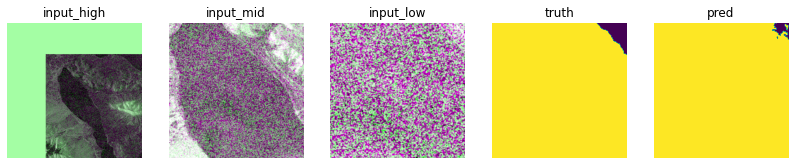

Ep111: Tra-> Loss:0.342,Oa:0.964,Miou:0.912, Val-> Loss:0.180,Oa:0.958,Miou:0.891,Time:12.0s
Ep112: Tra-> Loss:0.344,Oa:0.934,Miou:0.891, Val-> Loss:0.192,Oa:0.953,Miou:0.869,Time:11.7s
Ep113: Tra-> Loss:0.346,Oa:0.948,Miou:0.891, Val-> Loss:0.199,Oa:0.954,Miou:0.868,Time:11.9s
Ep114: Tra-> Loss:0.346,Oa:0.946,Miou:0.892, Val-> Loss:0.193,Oa:0.959,Miou:0.875,Time:11.8s
Ep115: Tra-> Loss:0.346,Oa:0.955,Miou:0.897, Val-> Loss:0.188,Oa:0.953,Miou:0.884,Time:11.9s
Ep116: Tra-> Loss:0.341,Oa:0.963,Miou:0.919, Val-> Loss:0.190,Oa:0.954,Miou:0.887,Time:11.8s
Ep117: Tra-> Loss:0.347,Oa:0.942,Miou:0.877, Val-> Loss:0.188,Oa:0.958,Miou:0.889,Time:11.8s
Ep118: Tra-> Loss:0.344,Oa:0.948,Miou:0.882, Val-> Loss:0.196,Oa:0.958,Miou:0.873,Time:11.9s
Ep119: Tra-> Loss:0.343,Oa:0.954,Miou:0.895, Val-> Loss:0.181,Oa:0.962,Miou:0.892,Time:11.8s
Ep120: Tra-> Loss:0.344,Oa:0.923,Miou:0.887, Val-> Loss:0.208,Oa:0.958,Miou:0.850,Time:11.4s


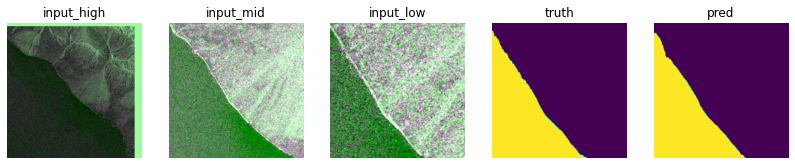

Ep121: Tra-> Loss:0.347,Oa:0.949,Miou:0.872, Val-> Loss:0.184,Oa:0.960,Miou:0.881,Time:11.9s
Ep122: Tra-> Loss:0.345,Oa:0.969,Miou:0.932, Val-> Loss:0.190,Oa:0.960,Miou:0.875,Time:11.7s
Ep123: Tra-> Loss:0.346,Oa:0.963,Miou:0.897, Val-> Loss:0.182,Oa:0.959,Miou:0.891,Time:11.7s
Ep124: Tra-> Loss:0.342,Oa:0.941,Miou:0.901, Val-> Loss:0.182,Oa:0.960,Miou:0.891,Time:12.1s
Ep125: Tra-> Loss:0.343,Oa:0.935,Miou:0.885, Val-> Loss:0.186,Oa:0.959,Miou:0.889,Time:11.8s
Ep126: Tra-> Loss:0.343,Oa:0.949,Miou:0.880, Val-> Loss:0.210,Oa:0.954,Miou:0.853,Time:11.7s
Ep127: Tra-> Loss:0.347,Oa:0.932,Miou:0.866, Val-> Loss:0.185,Oa:0.957,Miou:0.889,Time:11.8s
Ep128: Tra-> Loss:0.349,Oa:0.937,Miou:0.872, Val-> Loss:0.197,Oa:0.957,Miou:0.871,Time:11.9s
Ep129: Tra-> Loss:0.343,Oa:0.935,Miou:0.884, Val-> Loss:0.183,Oa:0.959,Miou:0.889,Time:12.3s
Ep130: Tra-> Loss:0.342,Oa:0.952,Miou:0.910, Val-> Loss:0.200,Oa:0.956,Miou:0.861,Time:11.8s


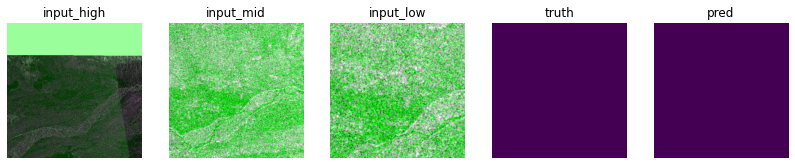

Ep131: Tra-> Loss:0.342,Oa:0.962,Miou:0.921, Val-> Loss:0.187,Oa:0.956,Miou:0.882,Time:11.6s
Ep132: Tra-> Loss:0.343,Oa:0.957,Miou:0.917, Val-> Loss:0.172,Oa:0.958,Miou:0.900,Time:12.0s
Ep133: Tra-> Loss:0.340,Oa:0.956,Miou:0.900, Val-> Loss:0.183,Oa:0.961,Miou:0.886,Time:11.5s
Ep134: Tra-> Loss:0.340,Oa:0.977,Miou:0.928, Val-> Loss:0.176,Oa:0.961,Miou:0.896,Time:12.1s
Ep135: Tra-> Loss:0.346,Oa:0.947,Miou:0.904, Val-> Loss:0.180,Oa:0.960,Miou:0.894,Time:11.7s
Ep136: Tra-> Loss:0.344,Oa:0.943,Miou:0.901, Val-> Loss:0.190,Oa:0.957,Miou:0.879,Time:11.8s
Ep137: Tra-> Loss:0.344,Oa:0.940,Miou:0.887, Val-> Loss:0.186,Oa:0.957,Miou:0.889,Time:11.9s
Ep138: Tra-> Loss:0.349,Oa:0.929,Miou:0.867, Val-> Loss:0.183,Oa:0.959,Miou:0.893,Time:11.6s
Ep139: Tra-> Loss:0.352,Oa:0.942,Miou:0.886, Val-> Loss:0.190,Oa:0.959,Miou:0.885,Time:11.6s
Ep140: Tra-> Loss:0.346,Oa:0.939,Miou:0.894, Val-> Loss:0.185,Oa:0.959,Miou:0.890,Time:11.4s


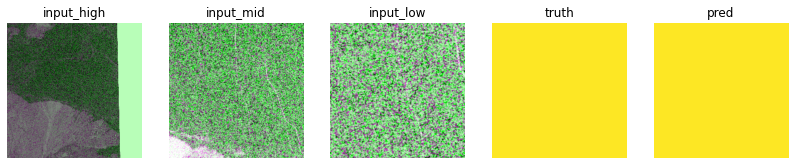

Ep141: Tra-> Loss:0.345,Oa:0.944,Miou:0.885, Val-> Loss:0.182,Oa:0.958,Miou:0.895,Time:11.7s
Ep142: Tra-> Loss:0.341,Oa:0.953,Miou:0.902, Val-> Loss:0.177,Oa:0.959,Miou:0.899,Time:11.7s
Ep143: Tra-> Loss:0.343,Oa:0.932,Miou:0.883, Val-> Loss:0.177,Oa:0.962,Miou:0.899,Time:11.5s
Ep144: Tra-> Loss:0.344,Oa:0.935,Miou:0.873, Val-> Loss:0.179,Oa:0.961,Miou:0.895,Time:11.8s
Ep145: Tra-> Loss:0.340,Oa:0.946,Miou:0.898, Val-> Loss:0.185,Oa:0.960,Miou:0.884,Time:12.3s
Ep146: Tra-> Loss:0.341,Oa:0.963,Miou:0.897, Val-> Loss:0.177,Oa:0.961,Miou:0.897,Time:11.5s
Ep147: Tra-> Loss:0.342,Oa:0.946,Miou:0.885, Val-> Loss:0.179,Oa:0.961,Miou:0.894,Time:11.7s
Ep148: Tra-> Loss:0.339,Oa:0.947,Miou:0.909, Val-> Loss:0.177,Oa:0.962,Miou:0.896,Time:11.7s
Ep149: Tra-> Loss:0.344,Oa:0.939,Miou:0.887, Val-> Loss:0.185,Oa:0.959,Miou:0.888,Time:11.6s
Ep150: Tra-> Loss:0.341,Oa:0.949,Miou:0.900, Val-> Loss:0.177,Oa:0.959,Miou:0.898,Time:11.8s


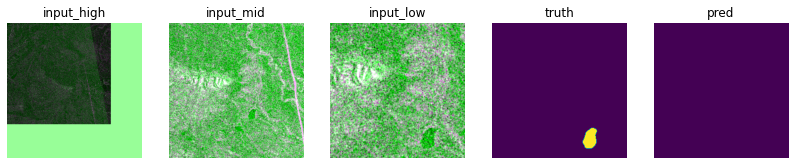

Ep151: Tra-> Loss:0.342,Oa:0.932,Miou:0.874, Val-> Loss:0.171,Oa:0.961,Miou:0.906,Time:11.6s
Ep152: Tra-> Loss:0.342,Oa:0.962,Miou:0.921, Val-> Loss:0.172,Oa:0.962,Miou:0.905,Time:11.8s
Ep153: Tra-> Loss:0.345,Oa:0.952,Miou:0.900, Val-> Loss:0.181,Oa:0.962,Miou:0.895,Time:11.6s
Ep154: Tra-> Loss:0.346,Oa:0.940,Miou:0.886, Val-> Loss:0.177,Oa:0.960,Miou:0.900,Time:11.9s
Ep155: Tra-> Loss:0.344,Oa:0.944,Miou:0.891, Val-> Loss:0.176,Oa:0.961,Miou:0.901,Time:12.0s
Ep156: Tra-> Loss:0.342,Oa:0.952,Miou:0.892, Val-> Loss:0.174,Oa:0.961,Miou:0.904,Time:11.6s
Ep157: Tra-> Loss:0.341,Oa:0.960,Miou:0.916, Val-> Loss:0.175,Oa:0.962,Miou:0.901,Time:12.1s
Ep158: Tra-> Loss:0.347,Oa:0.938,Miou:0.898, Val-> Loss:0.183,Oa:0.961,Miou:0.890,Time:11.9s
Ep159: Tra-> Loss:0.341,Oa:0.937,Miou:0.892, Val-> Loss:0.181,Oa:0.960,Miou:0.894,Time:11.5s
Ep160: Tra-> Loss:0.347,Oa:0.928,Miou:0.873, Val-> Loss:0.179,Oa:0.961,Miou:0.897,Time:11.7s


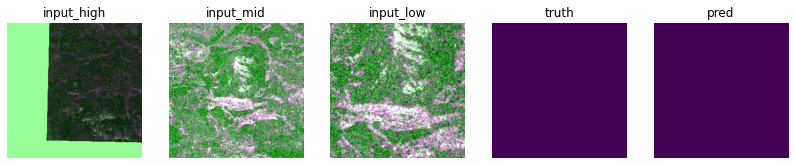

Ep161: Tra-> Loss:0.343,Oa:0.944,Miou:0.890, Val-> Loss:0.183,Oa:0.961,Miou:0.894,Time:11.6s
Ep162: Tra-> Loss:0.340,Oa:0.941,Miou:0.912, Val-> Loss:0.180,Oa:0.961,Miou:0.896,Time:11.4s
Ep163: Tra-> Loss:0.338,Oa:0.966,Miou:0.917, Val-> Loss:0.179,Oa:0.960,Miou:0.896,Time:11.7s
Ep164: Tra-> Loss:0.344,Oa:0.956,Miou:0.914, Val-> Loss:0.180,Oa:0.961,Miou:0.895,Time:11.9s
Ep165: Tra-> Loss:0.343,Oa:0.963,Miou:0.906, Val-> Loss:0.183,Oa:0.961,Miou:0.893,Time:11.4s
Ep166: Tra-> Loss:0.340,Oa:0.940,Miou:0.889, Val-> Loss:0.178,Oa:0.962,Miou:0.898,Time:11.6s
Ep167: Tra-> Loss:0.342,Oa:0.948,Miou:0.904, Val-> Loss:0.179,Oa:0.962,Miou:0.897,Time:11.6s
Ep168: Tra-> Loss:0.344,Oa:0.922,Miou:0.879, Val-> Loss:0.176,Oa:0.960,Miou:0.900,Time:12.1s
Ep169: Tra-> Loss:0.341,Oa:0.938,Miou:0.898, Val-> Loss:0.179,Oa:0.960,Miou:0.897,Time:12.2s
Ep170: Tra-> Loss:0.341,Oa:0.959,Miou:0.916, Val-> Loss:0.182,Oa:0.960,Miou:0.893,Time:11.9s


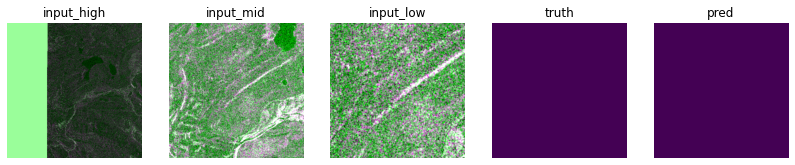

Ep171: Tra-> Loss:0.349,Oa:0.916,Miou:0.865, Val-> Loss:0.182,Oa:0.960,Miou:0.894,Time:11.5s
Ep172: Tra-> Loss:0.346,Oa:0.948,Miou:0.886, Val-> Loss:0.183,Oa:0.961,Miou:0.893,Time:12.0s
Ep173: Tra-> Loss:0.341,Oa:0.944,Miou:0.891, Val-> Loss:0.186,Oa:0.960,Miou:0.890,Time:11.8s
Ep174: Tra-> Loss:0.337,Oa:0.970,Miou:0.930, Val-> Loss:0.185,Oa:0.960,Miou:0.891,Time:11.6s
Ep175: Tra-> Loss:0.338,Oa:0.957,Miou:0.889, Val-> Loss:0.186,Oa:0.959,Miou:0.889,Time:11.6s
Ep176: Tra-> Loss:0.339,Oa:0.950,Miou:0.909, Val-> Loss:0.184,Oa:0.960,Miou:0.891,Time:11.9s
Ep177: Tra-> Loss:0.343,Oa:0.956,Miou:0.916, Val-> Loss:0.182,Oa:0.961,Miou:0.894,Time:11.7s
Ep178: Tra-> Loss:0.348,Oa:0.953,Miou:0.901, Val-> Loss:0.182,Oa:0.961,Miou:0.895,Time:11.7s
Ep179: Tra-> Loss:0.343,Oa:0.929,Miou:0.885, Val-> Loss:0.185,Oa:0.960,Miou:0.888,Time:12.0s
Ep180: Tra-> Loss:0.339,Oa:0.939,Miou:0.880, Val-> Loss:0.189,Oa:0.959,Miou:0.884,Time:11.5s


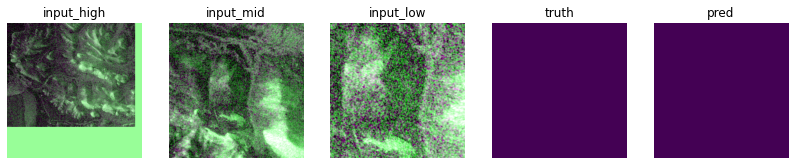

Ep181: Tra-> Loss:0.342,Oa:0.977,Miou:0.914, Val-> Loss:0.175,Oa:0.959,Miou:0.900,Time:11.6s
Ep182: Tra-> Loss:0.340,Oa:0.950,Miou:0.901, Val-> Loss:0.175,Oa:0.959,Miou:0.900,Time:11.7s
Ep183: Tra-> Loss:0.347,Oa:0.918,Miou:0.881, Val-> Loss:0.182,Oa:0.961,Miou:0.894,Time:11.8s
Ep184: Tra-> Loss:0.340,Oa:0.935,Miou:0.900, Val-> Loss:0.183,Oa:0.961,Miou:0.894,Time:11.8s
Ep185: Tra-> Loss:0.344,Oa:0.963,Miou:0.914, Val-> Loss:0.181,Oa:0.962,Miou:0.896,Time:11.9s
Ep186: Tra-> Loss:0.340,Oa:0.959,Miou:0.919, Val-> Loss:0.182,Oa:0.962,Miou:0.895,Time:11.7s
Ep187: Tra-> Loss:0.339,Oa:0.979,Miou:0.918, Val-> Loss:0.183,Oa:0.962,Miou:0.895,Time:11.7s
Ep188: Tra-> Loss:0.341,Oa:0.939,Miou:0.904, Val-> Loss:0.186,Oa:0.960,Miou:0.888,Time:11.5s
Ep189: Tra-> Loss:0.341,Oa:0.937,Miou:0.878, Val-> Loss:0.185,Oa:0.960,Miou:0.888,Time:11.7s
Ep190: Tra-> Loss:0.340,Oa:0.958,Miou:0.907, Val-> Loss:0.188,Oa:0.958,Miou:0.883,Time:12.0s


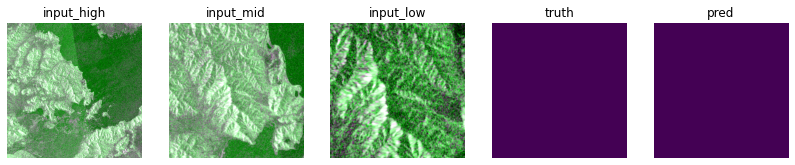

Ep191: Tra-> Loss:0.344,Oa:0.953,Miou:0.904, Val-> Loss:0.188,Oa:0.958,Miou:0.882,Time:11.9s
Ep192: Tra-> Loss:0.342,Oa:0.924,Miou:0.880, Val-> Loss:0.185,Oa:0.960,Miou:0.888,Time:11.9s
Ep193: Tra-> Loss:0.340,Oa:0.956,Miou:0.917, Val-> Loss:0.186,Oa:0.960,Miou:0.886,Time:11.7s
Ep194: Tra-> Loss:0.335,Oa:0.971,Miou:0.925, Val-> Loss:0.183,Oa:0.960,Miou:0.890,Time:11.8s
Ep195: Tra-> Loss:0.335,Oa:0.948,Miou:0.904, Val-> Loss:0.180,Oa:0.961,Miou:0.894,Time:11.9s
Ep196: Tra-> Loss:0.340,Oa:0.965,Miou:0.921, Val-> Loss:0.178,Oa:0.961,Miou:0.898,Time:11.9s
Ep197: Tra-> Loss:0.342,Oa:0.956,Miou:0.916, Val-> Loss:0.178,Oa:0.962,Miou:0.897,Time:11.6s
Ep198: Tra-> Loss:0.344,Oa:0.954,Miou:0.908, Val-> Loss:0.177,Oa:0.962,Miou:0.899,Time:12.3s
Ep199: Tra-> Loss:0.340,Oa:0.969,Miou:0.914, Val-> Loss:0.175,Oa:0.962,Miou:0.900,Time:12.0s
Ep200: Tra-> Loss:0.337,Oa:0.956,Miou:0.912, Val-> Loss:0.175,Oa:0.962,Miou:0.900,Time:12.1s


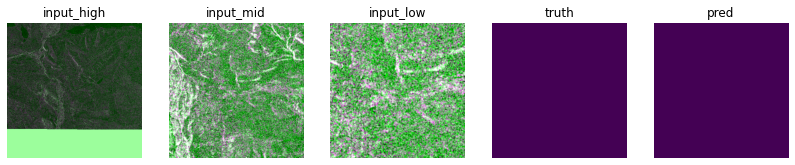

Ep201: Tra-> Loss:0.346,Oa:0.919,Miou:0.866, Val-> Loss:0.177,Oa:0.963,Miou:0.898,Time:11.8s
Ep202: Tra-> Loss:0.344,Oa:0.937,Miou:0.888, Val-> Loss:0.177,Oa:0.963,Miou:0.897,Time:11.5s
Ep203: Tra-> Loss:0.347,Oa:0.952,Miou:0.907, Val-> Loss:0.179,Oa:0.962,Miou:0.895,Time:12.3s
Ep204: Tra-> Loss:0.343,Oa:0.935,Miou:0.892, Val-> Loss:0.182,Oa:0.961,Miou:0.892,Time:11.9s
Ep205: Tra-> Loss:0.340,Oa:0.937,Miou:0.873, Val-> Loss:0.182,Oa:0.961,Miou:0.892,Time:12.4s
Ep206: Tra-> Loss:0.341,Oa:0.942,Miou:0.898, Val-> Loss:0.181,Oa:0.961,Miou:0.894,Time:11.8s
Ep207: Tra-> Loss:0.340,Oa:0.945,Miou:0.909, Val-> Loss:0.180,Oa:0.961,Miou:0.895,Time:12.1s
Ep208: Tra-> Loss:0.340,Oa:0.948,Miou:0.893, Val-> Loss:0.179,Oa:0.961,Miou:0.895,Time:11.8s
Ep209: Tra-> Loss:0.347,Oa:0.952,Miou:0.901, Val-> Loss:0.180,Oa:0.961,Miou:0.894,Time:11.6s
Ep210: Tra-> Loss:0.343,Oa:0.964,Miou:0.902, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.1s


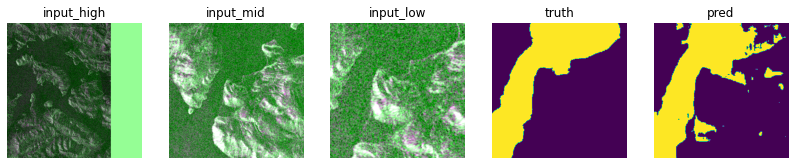

Ep211: Tra-> Loss:0.340,Oa:0.961,Miou:0.916, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.7s
Ep212: Tra-> Loss:0.343,Oa:0.937,Miou:0.891, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.6s
Ep213: Tra-> Loss:0.338,Oa:0.945,Miou:0.907, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s
Ep214: Tra-> Loss:0.340,Oa:0.947,Miou:0.899, Val-> Loss:0.180,Oa:0.961,Miou:0.894,Time:11.9s
Ep215: Tra-> Loss:0.345,Oa:0.950,Miou:0.888, Val-> Loss:0.181,Oa:0.961,Miou:0.893,Time:12.1s
Ep216: Tra-> Loss:0.340,Oa:0.949,Miou:0.913, Val-> Loss:0.183,Oa:0.961,Miou:0.891,Time:12.2s
Ep217: Tra-> Loss:0.338,Oa:0.969,Miou:0.934, Val-> Loss:0.184,Oa:0.961,Miou:0.889,Time:12.2s
Ep218: Tra-> Loss:0.344,Oa:0.954,Miou:0.888, Val-> Loss:0.182,Oa:0.961,Miou:0.892,Time:11.9s
Ep219: Tra-> Loss:0.342,Oa:0.954,Miou:0.896, Val-> Loss:0.181,Oa:0.961,Miou:0.893,Time:11.7s
Ep220: Tra-> Loss:0.339,Oa:0.957,Miou:0.917, Val-> Loss:0.181,Oa:0.961,Miou:0.893,Time:12.2s


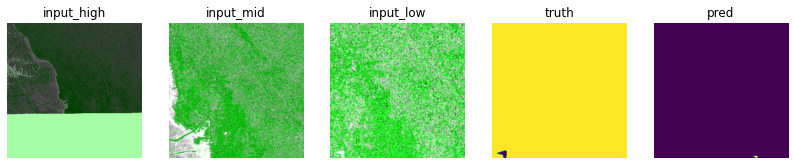

Ep221: Tra-> Loss:0.344,Oa:0.970,Miou:0.922, Val-> Loss:0.179,Oa:0.961,Miou:0.895,Time:11.7s
Ep222: Tra-> Loss:0.349,Oa:0.959,Miou:0.918, Val-> Loss:0.177,Oa:0.961,Miou:0.899,Time:12.0s
Ep223: Tra-> Loss:0.341,Oa:0.950,Miou:0.913, Val-> Loss:0.176,Oa:0.962,Miou:0.900,Time:11.8s
Ep224: Tra-> Loss:0.344,Oa:0.931,Miou:0.892, Val-> Loss:0.177,Oa:0.962,Miou:0.898,Time:12.0s
Ep225: Tra-> Loss:0.345,Oa:0.945,Miou:0.889, Val-> Loss:0.179,Oa:0.962,Miou:0.896,Time:11.8s
Ep226: Tra-> Loss:0.344,Oa:0.965,Miou:0.918, Val-> Loss:0.180,Oa:0.961,Miou:0.894,Time:11.7s
Ep227: Tra-> Loss:0.347,Oa:0.954,Miou:0.892, Val-> Loss:0.182,Oa:0.961,Miou:0.893,Time:11.8s
Ep228: Tra-> Loss:0.344,Oa:0.936,Miou:0.884, Val-> Loss:0.181,Oa:0.961,Miou:0.894,Time:12.0s
Ep229: Tra-> Loss:0.342,Oa:0.965,Miou:0.913, Val-> Loss:0.180,Oa:0.961,Miou:0.895,Time:11.9s
Ep230: Tra-> Loss:0.345,Oa:0.951,Miou:0.902, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.7s


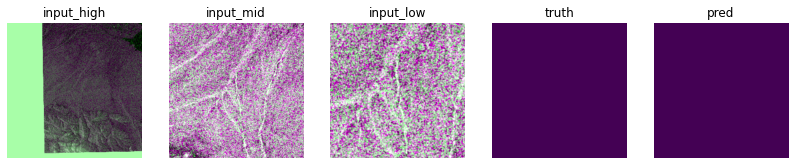

Ep231: Tra-> Loss:0.342,Oa:0.962,Miou:0.903, Val-> Loss:0.178,Oa:0.961,Miou:0.898,Time:12.2s
Ep232: Tra-> Loss:0.341,Oa:0.952,Miou:0.908, Val-> Loss:0.178,Oa:0.961,Miou:0.898,Time:11.9s
Ep233: Tra-> Loss:0.341,Oa:0.942,Miou:0.889, Val-> Loss:0.177,Oa:0.961,Miou:0.898,Time:12.1s
Ep234: Tra-> Loss:0.342,Oa:0.959,Miou:0.922, Val-> Loss:0.177,Oa:0.961,Miou:0.898,Time:12.4s
Ep235: Tra-> Loss:0.343,Oa:0.937,Miou:0.877, Val-> Loss:0.177,Oa:0.961,Miou:0.899,Time:11.8s
Ep236: Tra-> Loss:0.346,Oa:0.913,Miou:0.851, Val-> Loss:0.178,Oa:0.961,Miou:0.898,Time:11.6s
Ep237: Tra-> Loss:0.346,Oa:0.927,Miou:0.882, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.6s
Ep238: Tra-> Loss:0.341,Oa:0.959,Miou:0.920, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.8s
Ep239: Tra-> Loss:0.341,Oa:0.963,Miou:0.926, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.9s
Ep240: Tra-> Loss:0.340,Oa:0.937,Miou:0.894, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.5s


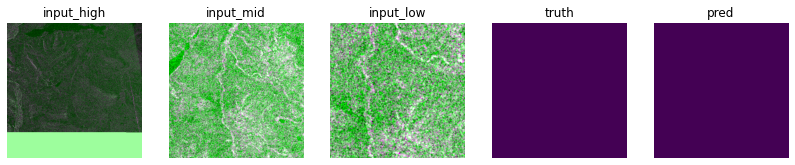

Ep241: Tra-> Loss:0.342,Oa:0.960,Miou:0.915, Val-> Loss:0.179,Oa:0.961,Miou:0.895,Time:11.9s
Ep242: Tra-> Loss:0.349,Oa:0.945,Miou:0.899, Val-> Loss:0.180,Oa:0.961,Miou:0.895,Time:12.3s
Ep243: Tra-> Loss:0.337,Oa:0.963,Miou:0.935, Val-> Loss:0.180,Oa:0.961,Miou:0.895,Time:11.7s
Ep244: Tra-> Loss:0.340,Oa:0.961,Miou:0.903, Val-> Loss:0.180,Oa:0.961,Miou:0.895,Time:11.6s
Ep245: Tra-> Loss:0.344,Oa:0.952,Miou:0.911, Val-> Loss:0.179,Oa:0.961,Miou:0.895,Time:11.9s
Ep246: Tra-> Loss:0.349,Oa:0.955,Miou:0.908, Val-> Loss:0.179,Oa:0.961,Miou:0.895,Time:11.7s
Ep247: Tra-> Loss:0.344,Oa:0.942,Miou:0.877, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.9s
Ep248: Tra-> Loss:0.346,Oa:0.930,Miou:0.856, Val-> Loss:0.179,Oa:0.961,Miou:0.897,Time:11.2s
Ep249: Tra-> Loss:0.343,Oa:0.906,Miou:0.865, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.6s
Ep250: Tra-> Loss:0.338,Oa:0.930,Miou:0.886, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s


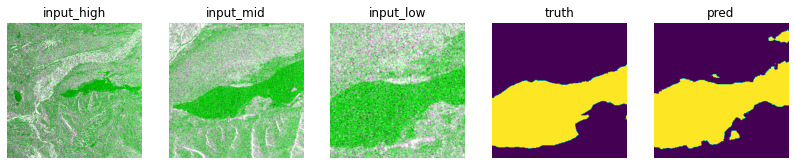

Ep251: Tra-> Loss:0.341,Oa:0.956,Miou:0.902, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s
Ep252: Tra-> Loss:0.341,Oa:0.965,Miou:0.919, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.8s
Ep253: Tra-> Loss:0.347,Oa:0.947,Miou:0.885, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s
Ep254: Tra-> Loss:0.340,Oa:0.947,Miou:0.906, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.6s
Ep255: Tra-> Loss:0.340,Oa:0.952,Miou:0.899, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.7s
Ep256: Tra-> Loss:0.343,Oa:0.970,Miou:0.920, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.6s
Ep257: Tra-> Loss:0.345,Oa:0.932,Miou:0.891, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep258: Tra-> Loss:0.346,Oa:0.949,Miou:0.917, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.8s
Ep259: Tra-> Loss:0.346,Oa:0.952,Miou:0.887, Val-> Loss:0.179,Oa:0.961,Miou:0.897,Time:11.6s
Ep260: Tra-> Loss:0.347,Oa:0.945,Miou:0.899, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s


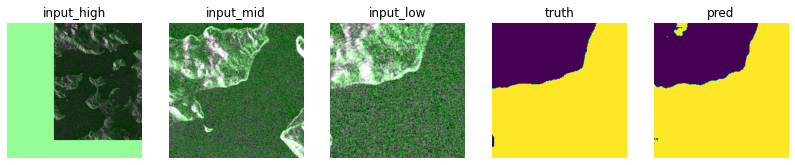

Ep261: Tra-> Loss:0.346,Oa:0.956,Miou:0.901, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.3s
Ep262: Tra-> Loss:0.341,Oa:0.952,Miou:0.904, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.8s
Ep263: Tra-> Loss:0.343,Oa:0.946,Miou:0.893, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.6s
Ep264: Tra-> Loss:0.347,Oa:0.933,Miou:0.878, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.5s
Ep265: Tra-> Loss:0.343,Oa:0.942,Miou:0.889, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.9s
Ep266: Tra-> Loss:0.344,Oa:0.964,Miou:0.899, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s
Ep267: Tra-> Loss:0.345,Oa:0.950,Miou:0.896, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:11.8s
Ep268: Tra-> Loss:0.339,Oa:0.965,Miou:0.920, Val-> Loss:0.179,Oa:0.961,Miou:0.896,Time:12.0s
Ep269: Tra-> Loss:0.339,Oa:0.961,Miou:0.920, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.0s
Ep270: Tra-> Loss:0.343,Oa:0.954,Miou:0.903, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.6s


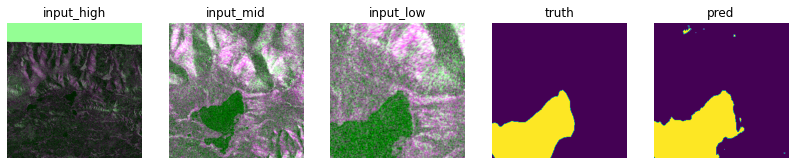

Ep271: Tra-> Loss:0.345,Oa:0.932,Miou:0.879, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.0s
Ep272: Tra-> Loss:0.349,Oa:0.952,Miou:0.899, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.1s
Ep273: Tra-> Loss:0.353,Oa:0.953,Miou:0.894, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.8s
Ep274: Tra-> Loss:0.343,Oa:0.954,Miou:0.905, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.8s
Ep275: Tra-> Loss:0.353,Oa:0.923,Miou:0.859, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep276: Tra-> Loss:0.347,Oa:0.934,Miou:0.891, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep277: Tra-> Loss:0.343,Oa:0.933,Miou:0.888, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.8s
Ep278: Tra-> Loss:0.340,Oa:0.954,Miou:0.891, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.5s
Ep279: Tra-> Loss:0.346,Oa:0.920,Miou:0.874, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.6s
Ep280: Tra-> Loss:0.344,Oa:0.943,Miou:0.894, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.5s


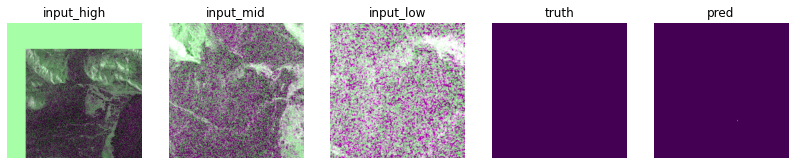

Ep281: Tra-> Loss:0.342,Oa:0.943,Miou:0.900, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.7s
Ep282: Tra-> Loss:0.344,Oa:0.966,Miou:0.917, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.0s
Ep283: Tra-> Loss:0.341,Oa:0.955,Miou:0.915, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep284: Tra-> Loss:0.339,Oa:0.929,Miou:0.879, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.6s
Ep285: Tra-> Loss:0.339,Oa:0.947,Miou:0.903, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.1s
Ep286: Tra-> Loss:0.342,Oa:0.952,Miou:0.904, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.1s
Ep287: Tra-> Loss:0.345,Oa:0.923,Miou:0.872, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.4s
Ep288: Tra-> Loss:0.343,Oa:0.908,Miou:0.851, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep289: Tra-> Loss:0.343,Oa:0.969,Miou:0.917, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.7s
Ep290: Tra-> Loss:0.345,Oa:0.940,Miou:0.903, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.5s


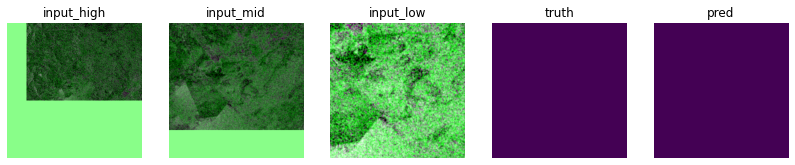

Ep291: Tra-> Loss:0.342,Oa:0.944,Miou:0.901, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.0s
Ep292: Tra-> Loss:0.342,Oa:0.931,Miou:0.873, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.7s
Ep293: Tra-> Loss:0.346,Oa:0.942,Miou:0.886, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.3s
Ep294: Tra-> Loss:0.343,Oa:0.945,Miou:0.886, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.1s
Ep295: Tra-> Loss:0.348,Oa:0.949,Miou:0.895, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.7s
Ep296: Tra-> Loss:0.343,Oa:0.958,Miou:0.896, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.6s
Ep297: Tra-> Loss:0.341,Oa:0.934,Miou:0.888, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep298: Tra-> Loss:0.342,Oa:0.953,Miou:0.911, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.8s
Ep299: Tra-> Loss:0.342,Oa:0.921,Miou:0.887, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:11.9s
Ep300: Tra-> Loss:0.342,Oa:0.958,Miou:0.916, Val-> Loss:0.178,Oa:0.961,Miou:0.897,Time:12.0s


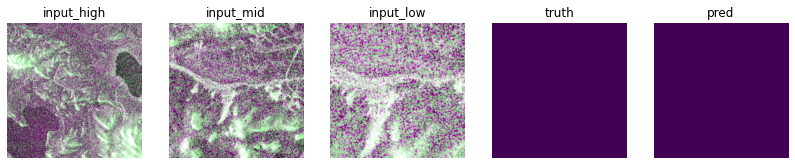

In [14]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce, 
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,  
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [ ]:
# model_type = 'gscales_with_traset'
# model_name = 'trained_1'
# # model save/load
# path_weights = config.root_proj + '/model/pretrained_model/' + model_type + '/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), path_weights)
# # model.load_state_dict(torch.load(path_weights)


In [ ]:
# ## metrics saving
# path_metrics = config.root_proj + '/model/pretrained_model/' + model_type + '/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')
# metrics_df = pd.read_csv(path_metrics)
